In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import base64
import string
import re
import warnings
import pickle

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier    
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score, accuracy_score, recall_score, cohen_kappa_score, classification_report , precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.externals import joblib
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mondeca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load data
with open('DATA.pkl', 'rb') as handle:
    X, Y, vocabs = pickle.load(handle)
    
X = np.array(X)

In [3]:
n = 490
print(vocabs[n])
X[n]

rooms


'Floor Section. Contains. Desk. Building. Floor. A space inside a structure, typically separated from the outside by exterior walls and from other rooms in the same structure by internal walls. A human-made structure used for sheltering or continuous occupancy. Site. A simple vocabulary for describing the rooms in a building. An agent that generally occupies the physical area of the subject resource. Having this property implies being a spatial object. Being the object of this property implies being an agent. Intended for use with buildings, rooms, desks, etc. Room. The object resource is physically and spatially contained in the subject resource. Being the subject or object of this property implies being a spatial object. Intended for use in the context of buildings, rooms, etc. A table used in a work or office setting, typically for reading, writing, or computer use. A named part of a floor of a building. Typically used to denote several rooms that are grouped together based on spati

In [4]:
print(len(X), len(Y), len(vocabs))

656 656 656


In [ ]:
# Study distribution of tags
import itertools
from collections import Counter

totals = Counter(i for i in list(itertools.chain.from_iterable(Y)))
distrib = dict(totals)
#distrib = sorted(distrib.items(), key=lambda x: x[1])

In [6]:
all_tags_len = np.sum(list(distrib.values()))
distrib_freq = {key:val/all_tags_len for key,val in distrib.items()}

In [73]:
sortedDistrib = sorted(distrib.items(), key = 
             lambda kv:(kv[1], kv[0]))
np.sum([x[1] for x in sortedDistrib])

798

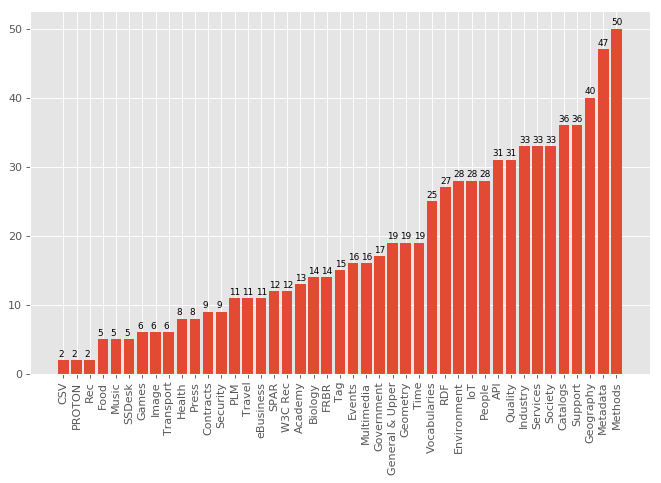

In [71]:
# Plot distribution
plt.style.use('ggplot')
plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.bar([x[0] for x in sortedDistrib], [x[1] for x in sortedDistrib])
plt.xticks(rotation='vertical', size = 10)
for i in range(len(sortedDistrib)):
    plt.text(x = i - 0.4 , y = sortedDistrib[i][1] + 0.5, s = sortedDistrib[i][1], size = 8)
#plt.savefig('LOVTagsStat.png', dpi=300)

In [5]:
# Return the number of uppercase in string
def num_uppercase(string):
    count = 0
    for l in string:
        if l.isupper():
            count += 1
    return count

# From a list of words, split the words with more than one uppercase
def split_uppercases(words):
    words_proc = []
    for word in words:
        if num_uppercase(word) >= 1 and not(word.isupper()):
            splitted_words = re.findall('[A-Za-z][a-z]*', word)
            for w in splitted_words:
                words_proc.append(w.lower())
        else:
            words_proc.append(word.lower())
    return words_proc

# Tokenizer
def Tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [word for word in words if word not in stopwords.words('english')]
    return words

# Tokenizer : use stems of words
def Tokenizer_lemm(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [word for word in words if word not in stopwords.words('english')]
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words

# new Tokenizer : split the strings in the form "jointAnnual" with a space in the text
def newTokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).split()
    words = split_uppercases(words)
    #porter_stemmer=nltk.PorterStemmer()
    words = [word for word in words if word not in stopwords.words('english')]
    #words = [porter_stemmer.stem(word) for word in words]
    return words

In [6]:
# Compare both tokenizer
[(x,y) for x,y in zip(Tokenizer(X[10]), newTokenizer(X[10]))][:10]

[('description', 'description'),
 ('knowledgegrouping', 'knowledge'),
 ('organization', 'grouping'),
 ('division', 'organization'),
 ('organizationalunit', 'division'),
 ('teaches', 'organizational'),
 ('institution', 'unit'),
 ('html', 'teaches'),
 ('subject', 'institution'),
 ('knowledgegrouping', 'html')]

In [7]:
# Study the CountVectorizer (WITHOUT NGRAMS)
CV = CountVectorizer(tokenizer=newTokenizer, min_df=.0025, max_df=0.25, ngram_range=(1,1))
CV.fit(X)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=0.0025,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function newTokenizer at 0x7f4b8af60400>,
        vocabulary=None)

In [10]:
print(len(CV.vocabulary_))

21435


In [11]:
X_vect = CV.transform(X)

In [12]:
print(X_vect.shape)
X_vect_np = X_vect.toarray()

(656, 21435)


In [13]:
# Mean of words per documents and min/max
print(np.mean(np.sum(X_vect_np, axis=1)))
print(np.min(np.sum(X_vect_np, axis=1)))
print(np.max(np.sum(X_vect_np, axis=1)))
#print(X_vect_np[0])

1168.5121951219512
0
86208


In [14]:
# Number of documents of 0 words or < 20 words
print(np.sum(np.sum(X_vect_np, axis=1) < 20))
print(np.sum(np.sum(X_vect_np, axis=1) == 0))

25
2


In [14]:
# Preprocessing pipeline : Vectorizer + tfidf + SVD
pipeline1 = Pipeline([
            ('tfidf', TfidfVectorizer(tokenizer=Tokenizer_lemm, min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=100, random_state=1))])

In [15]:
# Set of classifiers which work with multilabels
clfs = {
'RF': RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=50),
'MLP': MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(100),random_state=1),
'KPPV': KNeighborsClassifier(n_neighbors=7)
}

# Test function of different classifiers
def run_classifiers(clfs,X,Y, pipeline):
    # Apply processing pipeline
    X_proc = pipeline.fit_transform(X)
    # Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'precision_micro', 'recall_micro']
    for i in clfs:
        try:
            clf = clfs[i]
            print("\n\n======= {0} =======".format(i))
            y_pred = cross_val_predict(clf, X_proc, Y, cv=kf)
            print(classification_report(Y, y_pred))            
        except Exception as e:
            print(e)

In [16]:
# Transform multilablels Y in sparse matrix for sklearn
mlb = MultiLabelBinarizer(sparse_output=False)
Y_mlb = mlb.fit_transform(Y)

In [17]:
# Remove the tags with a low frequency inferior of seuil
# Some graphs will then not have any tags anymore, these graphs are the removed
def remove_low_frequencies(X, Y_mlb, vocabs, seuil = 0.02):
    labels_freqs = np.sum(Y_mlb, axis = 0) / np.sum(Y_mlb)
    # Keeps only labels with freq > seuil
    inds_col = labels_freqs > seuil
    Y_filt = Y_mlb * inds_col
    
    inds_0_col = np.where((Y_filt == 0).all(axis=0))[0]
    mask0 = np.ones(Y_filt.shape[1], np.bool)
    mask0[inds_0_col] = 0
    Y_filt_col = Y_filt[:,mask0]
    Y_filt_col.shape
    
    inds_0 = np.where((Y_filt_col == 0).all(axis=1))[0] # Indices of rows fully equals 0
    mask = np.ones(len(Y_filt_col), np.bool)
    mask[inds_0] = 0
    Y_filt_rows = Y_filt_col[mask,:]
    
    vocabs_filt = vocabs[mask]
    X_filt = X[mask]
    Y_filt = Y_filt_rows
    
    return X_filt, Y_filt, vocabs_filt

In [18]:
X_filt, Y_filt, vocabs_filt = remove_low_frequencies(X,Y_mlb, vocabs, seuil = 0.03)

In [19]:
print(X_filt.shape, Y_filt.shape, vocabs_filt.shape)

(424,) (424, 15) (424,)


In [20]:
# With only the most frequent tags
run_classifiers(clfs, X_filt, Y_filt, pipeline1)



======= RF =======


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.00      0.00      0.00        36
           2       0.00      0.00      0.00        28
           3       0.71      0.12      0.21        40
           4       0.00      0.00      0.00        33
           5       1.00      0.14      0.25        28
           6       0.00      0.00      0.00        47
           7       0.00      0.00      0.00        50
           8       1.00      0.07      0.13        28
           9       0.00      0.00      0.00        31
          10       0.00      0.00      0.00        27
          11       0.00      0.00      0.00        33
          12       1.00      0.06      0.11        33
          13       1.00      0.03      0.05        36
          14       0.00      0.00      0.00        25

   micro avg       0.70      0.03      0.05       506
   macro avg       0.31      0.03      0.05       506
weighted avg       0.30   

/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [21]:
# all tags, WITH LEMMATIZER 
run_classifiers(clfs, X, Y_mlb, pipeline1)



======= RF =======


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        36
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        28
           7       0.00      0.00      0.00        16
           8       0.40      0.14      0.21        14
           9       0.00      0.00      0.00         5
          10       1.00      0.50      0.67         6
          11       0.00      0.00      0.00        19
          12       1.00      0.15      0.26        40
          13       0.50      0.05      0.10        19
          14       0.00      0.00      0.00        17
          15       1.00      0.12      0.22         8
          16       0.00      0.00      0.00         6
          17       0.00    

/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 

In [43]:
# Preprocessing pipeline : No lemm
pipeline_nolemm = Pipeline([
            ('tfidf', TfidfVectorizer(tokenizer=Tokenizer, min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=100, random_state=1))])

# WITHOUT LEMMATIZER
run_classifiers(clfs, X, Y_mlb, pipeline_nolemm)



======= RF =======


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        36
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        28
           7       0.00      0.00      0.00        16
           8       1.00      0.07      0.13        14
           9       0.00      0.00      0.00         5
          10       1.00      0.33      0.50         6
          11       0.00      0.00      0.00        19
          12       1.00      0.10      0.18        40
          13       1.00      0.05      0.10        19
          14       0.00      0.00      0.00        17
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00         6
          17       0.00    

/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [25]:
# NEW TOKENIZER (ngram_range=1 lower the score of 1%)
pipeline2 = Pipeline([
            ('tfidf', TfidfVectorizer(tokenizer=newTokenizer, min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=150, random_state=1))])

In [26]:
# New tokenizer (split maj words) (BEST RESULTS)
run_classifiers(clfs, X, Y_mlb, pipeline2)



======= RF =======


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        36
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        28
           7       0.00      0.00      0.00        16
           8       1.00      0.14      0.25        14
           9       0.00      0.00      0.00         5
          10       1.00      0.50      0.67         6
          11       0.00      0.00      0.00        19
          12       1.00      0.10      0.18        40
          13       0.00      0.00      0.00        19
          14       0.00      0.00      0.00        17
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00         6
          17       0.00    

/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 

In [29]:
# MULTILABEL with other classifiers with ONEVSREST
clf_OvsR = {
'RF': OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)),
'BAGGING': OneVsRestClassifier(BaggingClassifier(n_estimators=100,random_state=1)),
'ADABOOST': OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, random_state=1)),
'SVC': OneVsRestClassifier(SVC(gamma='scale', decision_function_shape='ovo'))
}

run_classifiers(clf_OvsR, X, Y_mlb, pipeline2)



======= RF =======


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 24 is present in all training examples.
  str(classes[c]))
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        36
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        28
           7       0.00      0.00      0.00        16
           8       0.50      0.07      0.12        14
           9       0.00      0.00      0.00         5
          10       1.00      0.33      0.50         6
          11       0.00      0.00      0.00        19
          12       0.83      0.12      0.22        40
          13       1.00      0.05      0.10        19
          14       0.00      0.00      0.00        17
          15       1.00      0.12      0.22         8
          16       0.00      0.00      0.00         6
          17       0.00    

/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 24 is present in all training examples.
  str(classes[c]))
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.33      0.10      0.15        31
           1       0.00      0.00      0.00        13
           2       0.50      0.07      0.12        14
           3       0.00      0.00      0.00         2
           4       0.14      0.03      0.05        36
           5       0.00      0.00      0.00         9
           6       0.20      0.07      0.11        28
           7       0.00      0.00      0.00        16
           8       0.77      0.71      0.74        14
           9       0.00      0.00      0.00         5
          10       1.00      0.83      0.91         6
          11       0.20      0.05      0.08        19
          12       0.50      0.17      0.26        40
          13       0.50      0.16      0.24        19
          14       0.09      0.06      0.07        17
          15       0.50      0.12      0.20         8
          16       0.00      0.00      0.00         6
          17       0.00    

/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 24 is present in all training examples.
  str(classes[c]))
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.64      0.29      0.40        31
           1       0.33      0.08      0.12        13
           2       0.75      0.43      0.55        14
           3       0.00      0.00      0.00         2
           4       0.17      0.06      0.08        36
           5       0.00      0.00      0.00         9
           6       0.08      0.04      0.05        28
           7       0.67      0.12      0.21        16
           8       0.58      0.50      0.54        14
           9       0.00      0.00      0.00         5
          10       1.00      0.83      0.91         6
          11       0.25      0.05      0.09        19
          12       0.50      0.28      0.35        40
          13       0.57      0.42      0.48        19
          14       0.18      0.12      0.14        17
          15       1.00      0.12      0.22         8
          16       0.50      0.17      0.25         6
          17       0.19    

/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 24 is present in all training examples.
  str(classes[c]))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        36
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        28
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00        14
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00        19
          12       0.00      0.00      0.00        40
          13       0.00      0.00      0.00        19
          14       0.00      0.00      0.00        17
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00         6
          17       0.00    

/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [77]:
# MULTILABEL with other classifiers with ONEVSREST and weight classes
clf_OvsR_cb = {
'SVC': OneVsRestClassifier(SVC(C=10, gamma=1, kernel="rbf", decision_function_shape='ovo',class_weight="balanced")),
'SVC2': OneVsRestClassifier(SVC(C=5, gamma=1, kernel="rbf", decision_function_shape='ovo',class_weight="balanced")),
'SVC_poly': OneVsRestClassifier(SVC(C=10, gamma=1, kernel="poly", degree=5, decision_function_shape='ovo',class_weight="balanced")),
'SVC_lin': OneVsRestClassifier(SVC(C=10, gamma=1, kernel="linear", decision_function_shape='ovo',class_weight="balanced")),
'SVC_best': OneVsRestClassifier(SVC(C=5, gamma="auto", kernel="linear", decision_function_shape='ovo',class_weight="balanced"))
}

run_classifiers(clf_OvsR_cb, X, Y_mlb, pipeline2)



======= SVC =======


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 24 is present in all training examples.
  str(classes[c]))
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.63      0.39      0.48        31
           1       0.36      0.31      0.33        13
           2       0.62      0.57      0.59        14
           3       0.00      0.00      0.00         2
           4       0.29      0.25      0.27        36
           5       0.75      0.33      0.46         9
           6       0.31      0.36      0.33        28
           7       0.13      0.12      0.13        16
           8       0.54      0.50      0.52        14
           9       0.00      0.00      0.00         5
          10       1.00      1.00      1.00         6
          11       0.33      0.16      0.21        19
          12       0.47      0.47      0.48        40
          13       0.53      0.42      0.47        19
          14       0.30      0.41      0.35        17
          15       0.33      0.25      0.29         8
          16       0.50      0.17      0.25         6
          17       0.48    

/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 24 is present in all training examples.
  str(classes[c]))
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.60      0.39      0.47        31
           1       0.36      0.31      0.33        13
           2       0.57      0.57      0.57        14
           3       0.00      0.00      0.00         2
           4       0.30      0.25      0.27        36
           5       0.75      0.33      0.46         9
           6       0.37      0.39      0.38        28
           7       0.13      0.12      0.13        16
           8       0.54      0.50      0.52        14
           9       0.00      0.00      0.00         5
          10       1.00      1.00      1.00         6
          11       0.30      0.16      0.21        19
          12       0.43      0.45      0.44        40
          13       0.57      0.42      0.48        19
          14       0.33      0.53      0.41        17
          15       0.25      0.25      0.25         8
          16       0.50      0.17      0.25         6
          17       0.48    

/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 24 is present in all training examples.
  str(classes[c]))
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.71      0.16      0.26        31
           1       0.00      0.00      0.00        13
           2       0.67      0.29      0.40        14
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        36
           5       0.00      0.00      0.00         9
           6       0.21      0.11      0.14        28
           7       0.00      0.00      0.00        16
           8       0.56      0.36      0.43        14
           9       0.02      0.40      0.03         5
          10       1.00      0.67      0.80         6
          11       0.17      0.05      0.08        19
          12       0.64      0.23      0.33        40
          13       0.57      0.21      0.31        19
          14       0.24      0.24      0.24        17
          15       0.33      0.25      0.29         8
          16       0.00      0.00      0.00         6
          17       0.27    

/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 24 is present in all training examples.
  str(classes[c]))
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.52      0.52      0.52        31
           1       0.24      0.31      0.27        13
           2       0.57      0.57      0.57        14
           3       0.00      0.00      0.00         2
           4       0.25      0.39      0.30        36
           5       0.38      0.33      0.35         9
           6       0.27      0.46      0.34        28
           7       0.10      0.19      0.13        16
           8       0.56      0.64      0.60        14
           9       0.00      0.00      0.00         5
          10       1.00      1.00      1.00         6
          11       0.22      0.21      0.22        19
          12       0.35      0.57      0.43        40
          13       0.55      0.58      0.56        19
          14       0.27      0.47      0.34        17
          15       0.27      0.38      0.32         8
          16       0.17      0.17      0.17         6
          17       0.33    

/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 24 is present in all training examples.
  str(classes[c]))


              precision    recall  f1-score   support

           0       0.50      0.58      0.54        31
           1       0.19      0.31      0.24        13
           2       0.57      0.57      0.57        14
           3       0.00      0.00      0.00         2
           4       0.25      0.42      0.32        36
           5       0.30      0.33      0.32         9
           6       0.28      0.46      0.35        28
           7       0.10      0.19      0.13        16
           8       0.56      0.64      0.60        14
           9       0.00      0.00      0.00         5
          10       1.00      1.00      1.00         6
          11       0.26      0.26      0.26        19
          12       0.35      0.60      0.44        40
          13       0.55      0.58      0.56        19
          14       0.26      0.53      0.35        17
          15       0.25      0.38      0.30         8
          16       0.17      0.17      0.17         6
          17       0.33    

/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [32]:
# 22/07/2019 : Print only f1, precision and recall macro and micro. 
def run_classifiers_oneLine(clfs,X,Y, pipeline):
    # Apply processing pipeline
    X_proc = pipeline.fit_transform(X)
    # Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'precision_micro', 'recall_micro']
    for i in clfs:
        try:
            clf = clfs[i]
            print("\n\n======= {0} =======".format(i))
            y_pred = cross_val_predict(clf, X_proc, Y, cv=kf)
            print("f1-micro : ", f1_score(Y, y_pred, average="micro"))
            print("f1-macro : ", f1_score(Y, y_pred, average="macro"))
            print("precision-micro : ", precision_score(Y, y_pred, average="micro"))
            print("precision-macro : ", precision_score(Y, y_pred, average="macro"))
            print("recall-micro : ", recall_score(Y, y_pred, average="micro"))
            print("recall-macro : ", recall_score(Y, y_pred, average="macro"))
        except Exception as e:
            print(e)

# Test and compare the 4 algorithms for the research paper
clfs_alls = {
    'SVC': OneVsRestClassifier(SVC(C=10, gamma=1, kernel="rbf", decision_function_shape='ovo',class_weight="balanced")),
    #'BAGGING': OneVsRestClassifier(BaggingClassifier(n_estimators=100,random_state=1)),
    #'ADABOOST': OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, random_state=1)),
    'RF': RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=50),
    'MLP': MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(100),random_state=1),
    'KPPV': KNeighborsClassifier(n_neighbors=7)
}

In [33]:
run_classifiers_oneLine(clfs_alls, X, Y_mlb, pipeline2)



======= SVC =======


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 24 is present in all training examples.
  str(classes[c]))


f1-micro :  0.3557692307692307
f1-macro :  0.35336359177227267
precision-micro :  0.39361702127659576
precision-macro :  0.40762880382551
recall-micro :  0.32456140350877194
recall-macro :  0.32039621300152804


======= RF =======


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1-micro :  0.06682577565632458
f1-macro :  0.06901721691481266
precision-micro :  0.7
precision-macro :  0.20542635658914726
recall-micro :  0.03508771929824561
recall-macro :  0.04578375113258834


======= MLP =======


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1-micro :  0.3373801916932907
f1-macro :  0.32982596739991815
precision-micro :  0.34419817470664926
precision-macro :  0.3614551191673218
recall-micro :  0.3308270676691729
recall-macro :  0.3125979748071629


======= KPPV =======
f1-micro :  0.11428571428571428
f1-macro :  0.10757846767376039
precision-micro :  0.6493506493506493
precision-macro :  0.311046511627907
recall-micro :  0.06265664160401002
recall-macro :  0.07300206117831576


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

In [34]:
# Test SVD = 300
pipeline_SVD300 = Pipeline([
            ('tfidf', TfidfVectorizer(tokenizer=newTokenizer, min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300, random_state=1))])

run_classifiers_oneLine(clfs_alls, X, Y_mlb, pipeline_SVD300)



======= SVC =======


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 24 is present in all training examples.
  str(classes[c]))


f1-micro :  0.3091216216216216
f1-macro :  0.31245587351312865
precision-micro :  0.4740932642487047
precision-macro :  0.4619135262528377
recall-micro :  0.22932330827067668
recall-macro :  0.2469063215754428


======= RF =======


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1-micro :  0.041312272174969626
f1-macro :  0.04288188020077235
precision-micro :  0.68
precision-macro :  0.11627906976744186
recall-micro :  0.021303258145363407
recall-macro :  0.02747659317426759


======= MLP =======


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1-micro :  0.28774928774928776
f1-macro :  0.2861826157158443
precision-micro :  0.3333333333333333
precision-macro :  0.36331070264073284
recall-micro :  0.2531328320802005
recall-macro :  0.24769069693987572


======= KPPV =======


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1-micro :  0.11098527746319366
f1-macro :  0.10192207029590471
precision-micro :  0.5764705882352941
precision-macro :  0.2554909560723514
recall-micro :  0.06140350877192982
recall-macro :  0.07288901870603218


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
# Test SVD = 50
pipeline_SVD50 = Pipeline([
            ('tfidf', TfidfVectorizer(tokenizer=newTokenizer, min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=50, random_state=1))])

run_classifiers_oneLine(clfs_alls, X, Y_mlb, pipeline_SVD50)



======= SVC =======


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 24 is present in all training examples.
  str(classes[c]))


f1-micro :  0.3099688473520249
f1-macro :  0.30842251505823537
precision-micro :  0.2248587570621469
precision-macro :  0.25007437062788584
recall-micro :  0.49874686716791977
recall-macro :  0.43667438227054367


======= RF =======
f1-micro :  0.12399540757749714
f1-macro :  0.11954613153164868
precision-micro :  0.7397260273972602
precision-macro :  0.33242894056847544
recall-micro :  0.06766917293233082
recall-macro :  0.08171947122118876


======= MLP =======


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1-micro :  0.3278271918678526
f1-macro :  0.31706586792828495
precision-micro :  0.3324742268041237
precision-macro :  0.3384763975171446
recall-micro :  0.3233082706766917
recall-macro :  0.3066825620954641


======= KPPV =======
f1-micro :  0.1668472372697725
f1-macro :  0.15382053644410235
precision-micro :  0.616
precision-macro :  0.3488372093023256
recall-micro :  0.09649122807017543
recall-macro :  0.10748834376702288


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

In [455]:
#####################################
### KERAS MLP with class balanced ###


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import class_weight

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from keras import layers

In [577]:
# We will set the model for calling it with the Scikit learn API

np.random.seed(1)
epochs = 200
batch_size = 10
alpha=1e-5

# Create MLP model
def create_model(input_dim):
    model = Sequential()
    
    model.add(Dense(100, input_dim=input_dim, kernel_regularizer=regularizers.l2(1e-5),
                   activity_regularizer=regularizers.l2(1e-5)))
    model.add(Dropout(0.15))
    model.add(Activation('relu'))
    
    # Final layer
    model.add(Dense(len(Y_mlb[0])))
    model.add(Activation('sigmoid'))
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['categorical_accuracy'])
    return model

In [578]:
# class weights
class_weights = np.apply_along_axis(np.count_nonzero, 0, Y_mlb)

In [579]:
# Initialize model
model = create_model(input_dim=len(X_proc[0]))

In [53]:
# Process data
X_proc = pipeline2.fit_transform(X)

In [580]:
# Split between training and test set
X_train, X_test, y_train, y_test = train_test_split(X_proc, Y_mlb, test_size=0.20, random_state=1)

In [581]:
# Training
model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), class_weight=class_weights)

Train on 524 samples, validate on 132 samples
Epoch 1/200
524/524 [==============================] - 10s 19ms/step - loss: 0.6816 - categorical_accuracy: 0.0286 - val_loss: 0.6625 - val_categorical_accuracy: 0.0379
Epoch 2/200
524/524 [==============================] - 0s 327us/step - loss: 0.6415 - categorical_accuracy: 0.0324 - val_loss: 0.6159 - val_categorical_accuracy: 0.0303
Epoch 3/200
524/524 [==============================] - 0s 302us/step - loss: 0.5826 - categorical_accuracy: 0.0401 - val_loss: 0.5446 - val_categorical_accuracy: 0.0379
Epoch 4/200
524/524 [==============================] - 0s 271us/step - loss: 0.4965 - categorical_accuracy: 0.0515 - val_loss: 0.4485 - val_categorical_accuracy: 0.0455
Epoch 5/200
524/524 [==============================] - 0s 331us/step - loss: 0.3897 - categorical_accuracy: 0.0382 - val_loss: 0.3452 - val_categorical_accuracy: 0.0303
Epoch 6/200
524/524 [==============================] - 0s 328us/step - loss: 0.2906 - categorical_accuracy: 0

In [582]:
ypreds = model.predict(X_test)

In [583]:
ypreds_int = np.zeros_like(ypreds)
ypreds_int[ypreds>=0.5] = 1
ypreds_int[ypreds<0.5] = 0

In [584]:
ypreds

array([[5.7931244e-03, 3.9255321e-03, 1.4305204e-02, ..., 1.0032922e-02,
        1.1538655e-02, 4.7504604e-03],
       [4.3094158e-04, 2.8300285e-04, 8.6039305e-04, ..., 6.5535307e-05,
        1.7729402e-04, 3.1057894e-03],
       [2.3993820e-02, 2.3756027e-03, 5.2696198e-02, ..., 3.1572282e-03,
        4.3440163e-03, 5.6802630e-03],
       ...,
       [3.0794740e-04, 1.3528466e-03, 2.9908836e-02, ..., 1.3589859e-03,
        5.5104494e-04, 8.3342195e-04],
       [1.2870729e-03, 4.3887645e-02, 8.8682771e-04, ..., 1.5146434e-02,
        4.7052205e-03, 4.9856305e-04],
       [8.0657601e-03, 1.7917335e-02, 6.7669153e-04, ..., 1.5256833e-03,
        1.1959722e-03, 5.6374277e-04]], dtype=float32)

In [585]:
np.where(ypreds_int == 1)

(array([  3,   3,   7,   9,   9,  12,  13,  16,  18,  18,  21,  23,  24,
         24,  24,  25,  31,  34,  39,  40,  41,  42,  42,  43,  45,  46,
         50,  50,  51,  53,  54,  56,  57,  60,  61,  64,  65,  66,  67,
         72,  74,  75,  77,  80,  92,  92,  96,  97,  99, 100, 106, 110,
        114, 120, 122, 123, 124, 129]),
 array([ 2, 15, 40, 17, 39,  0,  4, 42,  6, 17, 37, 33, 19, 25, 34,  2,  0,
        12, 27, 13, 12,  6, 17, 17, 25, 25, 17, 33,  8, 32, 25,  4, 17, 20,
        21, 17,  4, 36,  4, 12, 37, 13, 19, 33,  6, 33, 42, 27, 17, 20, 13,
        32, 12, 17, 39, 10, 20, 20]))

In [586]:
f1_score(y_test, ypreds_int, average="micro")

0.2920353982300885

In [19]:
### BEST MLP PIPELINE
pipeline_mlp = Pipeline([
            ('tfidf', TfidfVectorizer(tokenizer=Tokenizer, min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=100, random_state=1)),
            ('MLP', MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(100),random_state=1))])

In [20]:
X_train, X_test, y_train, y_test, vocabs_train, vocabs_test = train_test_split(X, Y_mlb, vocabs, test_size=0.20, random_state=0)

In [198]:
# Training
pipeline_mlp.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=0.0025,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf...True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])

In [199]:
y_pred = pipeline_mlp.predict(X_test)

In [200]:
y_pred_probas = pipeline_mlp.predict_proba(X_test)

In [201]:
y_pred_probas

array([[1.61084114e-26, 3.03420474e-28, 1.97892467e-38, ...,
        6.45401528e-29, 4.43539277e-38, 1.25558894e-34],
       [1.35484764e-13, 1.18487097e-56, 1.98329224e-41, ...,
        6.35343769e-11, 4.07530161e-10, 1.88383652e-52],
       [1.76924771e-25, 3.42626342e-34, 1.11219954e-49, ...,
        2.56725686e-34, 4.22418826e-47, 2.40280405e-37],
       ...,
       [6.53904933e-52, 8.00590038e-31, 3.38471659e-37, ...,
        9.24587112e-28, 2.09201948e-39, 1.20330368e-46],
       [3.95278898e-84, 3.23055830e-38, 6.55220352e-72, ...,
        1.77668911e-33, 4.14978945e-97, 1.34202954e-86],
       [1.16159507e-26, 5.16314801e-25, 2.24881456e-53, ...,
        2.80328582e-30, 7.04062310e-55, 2.66813690e-27]])

In [202]:
# Get one tag for each prediction by the highest value in the predicted vector
row_maxs = y_pred_probas.max(axis=1, keepdims=True)
# Indices of maximum value for each row
y_pred1 = np.where(y_pred_probas == row_maxs, 1, 0)

In [203]:
# Compare prediction and true label
print(mlb.inverse_transform(y_pred1[:5]))
print(mlb.inverse_transform(y_test[:5]))
print(vocabs_test[:5])

[('Society',), ('RDF',), ('Services',), ('Environment',), ('Services',)]
[('API',), ('RDF',), ('Security',), ('Time',), ('Society',)]
['wdrs' 'rr' 'algo' 'interval' 'comm']


In [39]:
# It seems that labels are predicted if value of neuron > 0.5
print(y_pred_probas[4])
print(np.where(y_pred[4] == 1))

[1.54885587e-120 4.02558368e-033 4.97503419e-049 5.88969552e-042
 1.53312744e-071 2.28532802e-127 1.70999415e-094 1.06012728e-075
 5.04039157e-063 1.63265017e-037 4.36245761e-098 7.02502911e-054
 7.30329951e-092 3.08354532e-057 6.37495054e-116 2.31459374e-062
 1.27203227e-082 3.03122087e-105 1.59619395e-086 3.35553572e-066
 9.99999999e-001 4.90648356e-077 1.08729097e-073 5.49531645e-032
 9.07680576e-053 1.21609655e-106 4.90804301e-051 3.36449920e-006
 1.10067037e-060 3.58686655e-046 1.89011519e-028 3.55901399e-145
 1.06019624e-102 1.47854944e-059 7.19587903e-098 2.99722375e-014
 5.51782322e-062 8.25005058e-058 3.03752267e-067 2.98471665e-086
 6.40590116e-045 1.28706158e-083 2.42568169e-047]
(array([20]),)


In [204]:
print(f1_score(y_test, y_pred, average='micro'))
print(precision_score(y_test, y_pred, average="micro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="micro"))

0.26459143968871596
0.35051546391752575
0.25569895221058014
0.2125


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [6]:
def cust_metric(y_true, y_pred_proba):
    # Keep only one label with the higher proba
    row_maxs = y_pred_proba.max(axis=1, keepdims=True)
    # Indices of maximum value for each row
    maxis = np.where(y_pred_proba == row_maxs, 1, 0)
    # 1 if max value is indeed a tag, 0 otherwise
    check = y_true[maxis == 1]
    return np.mean(check)

In [19]:
print(cust_metric(y_test, y_pred_probas))

0.35365853658536583


In [24]:
#################################################
########### TRAIN MODEL WITH ALL DATA ###########
#################################################

pipeline_mlp = Pipeline([
            ('tfidf', TfidfVectorizer(tokenizer=Tokenizer, min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=100, random_state=1)),
            ('MLP', MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(100),random_state=1))])

In [25]:
pipeline_mlp.fit(X, Y_mlb)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=0.0025,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf...True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])

In [23]:
pipeline_mlp.predict(["events all the events i love"])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [24]:
# Save pipeline and mlb transformer
joblib.dump(pipeline_mlp, "clf.pkl")

joblib.dump(mlb, "mlb.pkl")

['mlb.pkl']

In [14]:
# Prediction on train set
y_pred = pipeline_mlp.predict(X_test)
print(f1_score(y_test, y_pred, average='micro'))
print(precision_score(y_test, y_pred, average="micro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="micro"))

0.9906542056074766
0.9875776397515528
0.8772609819121449
0.99375


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
#print(y_pred[:4])
#print(y_test[:4])

In [32]:
# TRAIN ALL DATA ON SVC (One-vs-Rest and class balanced)
pipeline_svc = Pipeline([
            ('tfidf', TfidfVectorizer(tokenizer=Tokenizer, min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=100, random_state=1)),
            ('SVC', OneVsRestClassifier(SVC(C=10, gamma=1, kernel="rbf", decision_function_shape='ovo',class_weight="balanced", probability=True)))
            ])

In [33]:
pipeline_svc.fit(X, Y_mlb)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=0.0025,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf...ility=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None))])

In [34]:
ynew_pred = pipeline_svc.predict(Xnew)
ynew_predProba = pipeline_svc.predict_proba(Xnew)

In [46]:
# Prediction on train set
y_pred = pipeline_svc.predict(X_test)
print(f1_score(y_test, y_pred, average='micro'))
print(precision_score(y_test, y_pred, average="micro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="micro"))

0.8664850136239782
0.7681159420289855
0.718175493756889
0.99375


/home/mondeca/applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
#######################
# Load new LoV vocabs #
#######################

with open('newDATA.pkl', 'rb') as handle:
    Xnew, vocabs = pickle.load(handle)
    
Xnew = np.array(Xnew)

In [44]:
import pprint

def getTags(pipeline, Xdata):
    ynew_pred = pipeline.predict(Xnew)
    ynew_predProba = pipeline.predict_proba(Xnew)
    
    # Get one tag for each prediction by the highest value in the predicted vector
    row_maxs = ynew_predProba.max(axis=1, keepdims=True)
    # Indices of maximum value for each row
    ynew_pred1 = np.where(ynew_predProba == row_maxs, 1, 0)
    
    print(vocabs)
    newPreds = mlb.inverse_transform(ynew_pred)
    newPreds1 = mlb.inverse_transform(ynew_pred1)
    
    pp = pprint.PrettyPrinter()
    pp.pprint([(x,y,z) for x,y,z in zip(vocabs, newPreds, newPreds1)])

In [47]:
getTags(pipeline_mlp, Xnew)

['UsabilityOntology.rdf', 'cultural-event.owl', 'munc.owl', 'catalogue.owl', 'terms.ttl', 'denotative-description.owl', 'context-description.owl', 'ontology.ttl', 'location.owl', 'core.owl', 'vir.ttl', 'arco.owl']
[('UsabilityOntology.rdf', (), ('API',)),
 ('cultural-event.owl', ('Events', 'Multimedia'), ('Events',)),
 ('munc.owl', ('RDF',), ('RDF',)),
 ('catalogue.owl', ('Catalogs', 'Government'), ('Government',)),
 ('terms.ttl', ('General & Upper', 'Services'), ('General & Upper',)),
 ('denotative-description.owl',
  ('Catalogs', 'Events', 'Government'),
  ('Catalogs',)),
 ('context-description.owl',
  ('Catalogs', 'Events', 'Multimedia'),
  ('Catalogs',)),
 ('ontology.ttl', ('Industry', 'Services'), ('Industry',)),
 ('location.owl', (), ('Events',)),
 ('core.owl', ('Events',), ('Events',)),
 ('vir.ttl', (), ('Support',)),
 ('arco.owl', ('Catalogs', 'Events', 'Multimedia'), ('Catalogs',))]


In [45]:
getTags(pipeline_svc, Xnew)

['UsabilityOntology.rdf', 'cultural-event.owl', 'munc.owl', 'catalogue.owl', 'terms.ttl', 'denotative-description.owl', 'context-description.owl', 'ontology.ttl', 'location.owl', 'core.owl', 'vir.ttl', 'arco.owl']
[('UsabilityOntology.rdf', (), ('API',)),
 ('cultural-event.owl',
  ('Catalogs', 'Events', 'Government', 'Multimedia'),
  ('Catalogs',)),
 ('munc.owl', (), ('RDF',)),
 ('catalogue.owl',
  ('Catalogs', 'Events', 'Government', 'Multimedia'),
  ('Catalogs',)),
 ('terms.ttl', ('General & Upper', 'RDF', 'Services'), ('RDF',)),
 ('denotative-description.owl',
  ('Catalogs', 'Environment', 'Events', 'Government', 'Multimedia'),
  ('Catalogs',)),
 ('context-description.owl',
  ('Catalogs', 'Environment', 'Events', 'Government', 'Multimedia'),
  ('Catalogs',)),
 ('ontology.ttl', ('Industry', 'Services'), ('Industry',)),
 ('location.owl',
  ('Catalogs', 'Events', 'Government', 'Multimedia'),
  ('Catalogs',)),
 ('core.owl',
  ('Catalogs', 'Events', 'Government', 'Multimedia'),
  ('Catal

In [17]:
# Get one tag for each prediction by the highest value in the predicted vector
row_maxs = ynew_predProba.max(axis=1, keepdims=True)
# Indices of maximum value for each row
ynew_pred1 = np.where(ynew_predProba == row_maxs, 1, 0)

In [18]:
print(vocabs)
newPreds = mlb.inverse_transform(ynew_pred)
newPreds1 = mlb.inverse_transform(ynew_pred1)

['UsabilityOntology.rdf', 'cultural-event.owl', 'munc.owl', 'catalogue.owl', 'terms.ttl', 'denotative-description.owl', 'context-description.owl', 'ontology.ttl', 'location.owl', 'core.owl', 'vir.ttl', 'arco.owl']


In [19]:
[(x,y,z) for x,y,z in zip(vocabs, newPreds, newPreds1)]

[('UsabilityOntology.rdf', (), ('API',)),
 ('cultural-event.owl', ('Events', 'Multimedia'), ('Events',)),
 ('munc.owl', ('RDF',), ('RDF',)),
 ('catalogue.owl', ('Catalogs', 'Government'), ('Government',)),
 ('terms.ttl', ('General & Upper', 'Services'), ('General & Upper',)),
 ('denotative-description.owl',
  ('Catalogs', 'Events', 'Government'),
  ('Catalogs',)),
 ('context-description.owl',
  ('Catalogs', 'Events', 'Multimedia'),
  ('Catalogs',)),
 ('ontology.ttl', ('Industry', 'Services'), ('Industry',)),
 ('location.owl', (), ('Events',)),
 ('core.owl', ('Events',), ('Events',)),
 ('vir.ttl', (), ('Support',)),
 ('arco.owl', ('Catalogs', 'Events', 'Multimedia'), ('Catalogs',))]

In [ ]:
####################################

In [38]:
# TEST RANDOM FOREST
pipeline_RF = Pipeline([
            ('tfidf', TfidfVectorizer(tokenizer=Tokenizer, min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=100, random_state=1)),
            ('RF', RandomForestClassifier(n_estimators=200, random_state=1, n_jobs=50))])

In [39]:
# Training
pipeline_RF.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=0.0025,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf...timators=200, n_jobs=50,
            oob_score=False, random_state=1, verbose=0, warm_start=False))])

In [48]:
y_pred = pipeline_RF.predict(X_test)

In [51]:
y_pred[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [40]:
y_pred_probas = pipeline_RF.predict_proba(X_test)

In [66]:
y_pred_probas_proc = np.array(y_pred_probas)
y_pred_probas_proc = y_pred_probas_proc[:,:,1].T
y_pred_probas_proc.shape

(132, 43)

In [67]:
y_pred_probas_proc

array([[0.04 , 0.02 , 0.005, ..., 0.03 , 0.025, 0.   ],
       [0.15 , 0.01 , 0.005, ..., 0.075, 0.065, 0.   ],
       [0.02 , 0.005, 0.035, ..., 0.035, 0.015, 0.005],
       ...,
       [0.015, 0.01 , 0.015, ..., 0.055, 0.03 , 0.   ],
       [0.02 , 0.005, 0.   , ..., 0.02 , 0.   , 0.005],
       [0.04 , 0.06 , 0.015, ..., 0.015, 0.01 , 0.01 ]])

In [65]:
y_pred_probas_proc.T.shape

(132, 43)

In [69]:
print(cust_metric(y_test, y_pred_probas_proc))

0.3333333333333333


In [ ]:
#################################################
############## DOC2VEC approach #################
#################################################

In [223]:
from gensim.models.doc2vec import TaggedDocument

# Split (get explicit labels and no mlb)
X_train, X_test, y_train, y_test, vocabs_train, vocabs_test = train_test_split(X, Y, vocabs, test_size=0.20, random_state=0)

In [224]:
train_tagged = [TaggedDocument(words = Tokenizer(doc), tags=tags) for doc, tags in zip(X_train, y_train)]
test_tagged = [TaggedDocument(words = Tokenizer(doc), tags=tags) for doc, tags in zip(X_test, y_test)]

In [225]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [226]:
from gensim.models import Doc2Vec
from tqdm import tqdm
from sklearn import utils

np.random.seed(0)

# Building vocab
model_dbow = Doc2Vec(dm=0, vector_size=300, window = 5,  negative=10, hs=0, min_count=2, sample = 0, workers=cores, seed=0)
model_dbow.build_vocab([x for x in tqdm(train_tagged)])

100%|██████████| 524/524 [00:00<00:00, 1213592.10it/s]


In [227]:
%%time
model_dbow.train(train_tagged, total_examples=len(train_tagged), epochs=30)

CPU times: user 3min 1s, sys: 625 ms, total: 3min 2s
Wall time: 25.3 s


In [228]:
# Transform text 
def doc_to_vec(X_tagged):
    vect = [model_dbow.infer_vector(x[0]) for x in X_tagged]
    return np.array(vect)

In [229]:
X_train_vect = doc_to_vec(train_tagged)
X_test_vect = doc_to_vec(test_tagged)

In [230]:
X_train_vect.shape

(524, 300)

In [231]:
y_train_mlb = mlb.transform(y_train)
y_test_mlb = mlb.transform(y_test)

In [233]:
#y_train_mlb

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [234]:
mlp = MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(200, 100),random_state=1)

In [235]:
mlp.fit(X_train_vect, y_train_mlb)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [236]:
y_pred = mlp.predict(X_test_vect)
y_pred_proba = mlp.predict_proba(X_test_vect)

In [237]:
f1_score(y_test_mlb, y_pred, average="micro")

0.29687499999999994

In [238]:
cust_metric(y_test_mlb, y_pred_proba)

0.3106060606060606

In [175]:
rf = RandomForestClassifier(random_state=0, n_estimators=200)

In [176]:
rf.fit(X_train_vect, y_train_mlb)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [179]:
y_pred = rf.predict(X_test_vect)
y_pred_proba = rf.predict_proba(X_test_vect)
y_pred_probas_proc = np.array(y_pred_probas)
y_pred_probas_proc = y_pred_probas_proc[:,:,1].T

In [181]:
print(f1_score(y_test_mlb, y_pred, average="micro"))
cust_metric(y_test_mlb, y_pred_probas_proc)

0.03592814371257485


0.3333333333333333

In [71]:
#### GRID SEARCH FOR SVC ####

svc = OneVsRestClassifier(SVC(class_weight="balanced"), n_jobs=-1)
            
params={'estimator__C':[1, 5, 10],
        'estimator__kernel':["rbf", "sigmoid", "linear"],
        'estimator__gamma':['auto', 1, 2],
        'estimator__decision_function_shape' : ["ovo", "ovr"]
        }

In [72]:
svc.get_params().keys()

dict_keys(['estimator__C', 'estimator__cache_size', 'estimator__class_weight', 'estimator__coef0', 'estimator__decision_function_shape', 'estimator__degree', 'estimator__gamma', 'estimator__kernel', 'estimator__max_iter', 'estimator__probability', 'estimator__random_state', 'estimator__shrinking', 'estimator__tol', 'estimator__verbose', 'estimator', 'n_jobs'])

In [73]:
gs = GridSearchCV(svc, params, cv=3, scoring="f1_micro")
gs.fit(X_proc,Y_mlb)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          n_jobs=-1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator__C': [1, 5, 10], 'estimator__kernel': ['rbf', 'sigmoid', 'linear'], 'estimator__gamma': ['auto', 1, 2], 'estimator__decision_function_shape': ['ovo', 'ovr']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0)

In [74]:
gs.best_params_

{'estimator__C': 5,
 'estimator__decision_function_shape': 'ovo',
 'estimator__gamma': 'auto',
 'estimator__kernel': 'linear'}